# Imports and Constants

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
import random
import os

import decoding
from savingOutputs import *
from loadData import *
from masks import *
from decoding import *
from plots import *
from utility import *

In [10]:
SEED = 0
random.seed(SEED)
classes = ['Up', 'Down', 'Right', 'Left']
nb_runs = 12
length = nb_runs * len(classes)
subjects_ids = range(1, 24)  # TODO modify this to get all subjects (here we only have 1 for the example)
n_subjects = len(subjects_ids)
n_perms = 1000
class_labels = [""] * (2 * length)
for i in range(length * 2):
    class_labels[i] = classes[(i // nb_runs) % len(classes)]
labels = dict()
labels["vis"] = np.array(class_labels[:length])
labels["aud"] = np.array(class_labels[length:])
labels_same = labels["vis"]

classical_tasks_regions = [(["vis"], ["V5_R", "V5_L"]),
                           (["aud"], ["PT_R", "PT_L"]),
                           (["aud"], ["V5_R", "V5_L"])]

cross_modal_task_regions = [(["vis", "aud"], ["V5_R", "V5_L"])]

scaler = sklearn.preprocessing.StandardScaler()
classifier = sklearn.svm.SVC(C = 1, kernel = 'linear', random_state=SEED)  # other parameters are default parameters
pipeline = Pipeline([('std', scaler), ('svm', classifier)])
decoder = Decoder(n_perm=n_perms, model=pipeline, n_classes=len(classes), n_splits=nb_runs, seed=SEED)

# Loading data

In [3]:
scores_perms = [dict() for _ in subjects_ids]
maps_masked = [dict() for _ in subjects_ids]

In [4]:
for i, subj_id in enumerate(subjects_ids):
    t_maps, beta_maps = get_maps([subj_id])
    masks = get_masks([subj_id], plot=False)
    maps = apply_mask_to_maps(t_maps, masks)
    maps_masked[i]["vis"] = get_part_of_maps(maps, 0, length)  # maps acquired for the vision experiment
    maps_masked[i]["aud"] = get_part_of_maps(maps, length, 2 * length)  # maps acquired for the audition experiment
    del t_maps ; del beta_maps ; del masks  # to relieve memory

# Within-modality decoding

In [ ]:
cv_scores = [dict() for _ in subjects_ids]
p_values = [dict() for _ in subjects_ids]
for i, subj_id in enumerate(subjects_ids):
    # within-modality decoding : training on a task and decoding on other samples from same task
    for tasks, regions in classical_tasks_regions:
        cv_sc, p_val, scores_perm = decoder.classify_tasks_regions(maps_masked[i], labels, tasks, regions)
        cv_scores[i].update(cv_sc)
        p_values[i].update(p_val)
        scores_perms[i].update(scores_perm)
    print("Within-modality decoding done for subject "+str(subj_id)+"/"+str(n_subjects))

In [6]:
# Compute groups results
within_modality_group_results = average_dicos(cv_scores)
within_modality_p_values = average_dicos(p_values)

# Cross-modal decoding

In [13]:
cv_scores = [dict() for _ in subjects_ids]
#p_values = [dict() for _ in subjects_ids]
for i, subj_id in enumerate(subjects_ids):
    # cross-modal decoding : training on a task and decoding on samples from another task
    for tasks, regions in cross_modal_task_regions:
        scores_cross_mod = decoder.cross_modal_decoding(maps_masked[i], labels, tasks, regions)
        cv_scores[i].update(scores_cross_mod)

    print("Cross-modal decoding done for subject "+str(subj_id)+"/"+str(n_subjects))

Cross-modal decoding done for subject 1/23
Cross-modal decoding done for subject 2/23
Cross-modal decoding done for subject 3/23
Cross-modal decoding done for subject 4/23
Cross-modal decoding done for subject 5/23
Cross-modal decoding done for subject 6/23
Cross-modal decoding done for subject 7/23
Cross-modal decoding done for subject 8/23
Cross-modal decoding done for subject 9/23
Cross-modal decoding done for subject 10/23
Cross-modal decoding done for subject 11/23
Cross-modal decoding done for subject 12/23
Cross-modal decoding done for subject 13/23
Cross-modal decoding done for subject 14/23
Cross-modal decoding done for subject 15/23
Cross-modal decoding done for subject 16/23
Cross-modal decoding done for subject 17/23
Cross-modal decoding done for subject 18/23
Cross-modal decoding done for subject 19/23
Cross-modal decoding done for subject 20/23
Cross-modal decoding done for subject 21/23
Cross-modal decoding done for subject 22/23
Cross-modal decoding done for subject 23/

In [12]:
# Compute groups results
cross_modality_group_results = average_dicos(cv_scores)
# cross_modality_p_values = average_dicos(p_values)

# Bootstrapping to assess group-level significance

In [9]:
n_single_perm = 100
n_bootstrap = 100_000

In [10]:
within_scores_100_perm = decoder.score_bootstrapped_permutations(n_single_perm, labels_same,classical_tasks_regions,maps_masked,n_subjects, within_modality=True)
bootstrapped_distribution_within = compute_bootstrap_distribution(n_bootstrap, n_subjects, within_scores_100_perm, n_single_perm)

Running models done in 321.3514404296875 seconds
Running models done in 9.22202754020691 seconds


In [11]:
cross_scores_100_perm = decoder.score_bootstrapped_permutations(100, labels_same,cross_modal_task_regions,maps_masked,n_subjects, within_modality=False)
bootstrapped_distribution_cross = compute_bootstrap_distribution(n_bootstrap, n_subjects, cross_scores_100_perm, n_single_perm)

Running models done in 21.630046844482422 seconds
Running models done in 7.927947282791138 seconds


# Saving results

In [12]:
create_directory("out")
save_dicts("cv_scores.csv", cv_scores, list(cv_scores[0].keys()), subjects_ids)
save_dicts("p_values.csv", p_values, list(p_values[0].keys()), subjects_ids)
save_dicts_perms("scores_perms.csv", scores_perms, subjects_ids)
save_dicts("group_scores_within.csv", [within_modality_group_results], list(within_modality_group_results.keys()), [0])
save_dicts("group_scores_cross.csv", [cross_modality_group_results], list(cross_modality_group_results.keys()), [0])

In [13]:
save_dicts("bootstraps_within.csv", [average_dicos(bootstrapped_distribution_within)], list(bootstrapped_distribution_within[0].keys()), [0])
save_dicts("bootstraps_cross.csv", [average_dicos(bootstrapped_distribution_cross)], list(bootstrapped_distribution_cross[0].keys()), [0])

# Plotting results (from files of saved results)

In [15]:
plt_directory = "plots"
create_directory(plt_directory)

cv_within_df = pd.read_csv("out/group_scores_within.csv", index_col=0)
cv_cross_df = pd.read_csv("out/group_scores_cross.csv", index_col=0)
for col in cv_cross_df.columns: cv_within_df[col] = cv_cross_df[col]

bootstrap_within_df = pd.read_csv("out/bootstraps_within.csv", index_col=0)
bootstrap_cross_df = pd.read_csv("out/bootstraps_cross.csv", index_col=0)
for col in bootstrap_cross_df.columns: bootstrap_within_df[col] = bootstrap_cross_df[col]
#pv_df = pd.read_csv("out/p_values.csv", index_col=0)
perm_df = pd.read_csv("out/scores_perms.csv", index_col=0)

plotter = Plotter(plt_directory, subjects_ids)
plotter.plot_cv_pval(cv_within_df, "cv score", plotter.cv_scores_dir, chance_level = True)
plotter.plot_cv_pval(bootstrap_within_df, "bootstrap", plotter.bootstrap_dir, chance_level = True)
#plotter.plot_cv_pval(pv_df, "p-value", plotter.p_values_dir)
plotter.plot_perms_scores(perm_df, n_perms)

In [ ]:
# group-level results
# TODO

# Visualizing differences between audition and vision in the voxels of a ROI (TO BE DELETED)

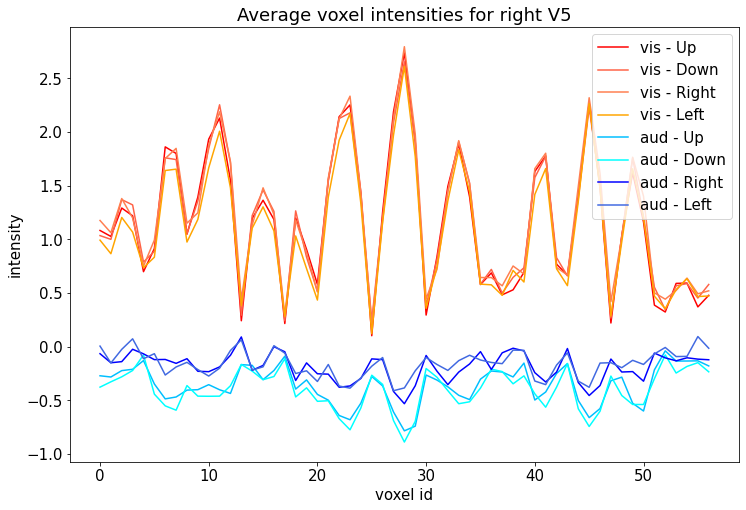

In [16]:
region = "V5_R"
colors = ["red","tomato","coral","orange","deepskyblue","cyan","blue","royalblue"]
n_voxels = maps_masked[0]["vis"][0][region].shape[1]
mean_aud = dict()
mean_vis = dict()

for cla in classes :
    mean_aud[cla] = np.zeros(n_voxels)
    mean_vis[cla] = np.zeros(n_voxels)


for i in range(n_subjects):
    for j, cla in enumerate(classes) :
        mean_vis[cla] += np.mean(maps_masked[i]["vis"][0][region][j*12:(j+1)*12],axis=0)/n_subjects
        mean_aud[cla] += np.mean(maps_masked[i]["aud"][0][region][j*12:(j+1)*12],axis=0)/n_subjects

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(12,8))

idx = 0
for cla in classes :
    plt.plot(range(n_voxels), mean_vis[cla], label = "vis - "+cla, color = colors[idx])
    idx += 1

for cla in classes :
    plt.plot(range(n_voxels), mean_aud[cla], label = "aud - "+cla, color = colors[idx])
    idx += 1

plt.xlabel("voxel id")
plt.ylabel("intensity")
plt.title("Average voxel intensities for right V5")
plt.legend()
plt.savefig("plots/why_normalize_cross_modal.png")